In [33]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from fna.tools.signals import make_simple_kernel, pad_array

import os
import sys
import re
import sys

import pickle

plt.rcParams.update({'font.size' : 14})

In [3]:
sys.path.append("../demyelination/") # we need this to successfully read pickle files
sys.path.append("../") # we need this to successfully read pickle files

In [4]:
def gatherSpikes(path, filename, nthreads, brainPart, neuronIdFirst, neuronIdLast):
    '''
    Example Usage: 
    gatherSpikes("demyelination/data/adaptation-aone-plast/activity/", \
                 "spk_adaptation-aone-plast_T=0_nuX_aone=20.0_gamma_aone=9.0_w_input_aone=15.0_", \
                 2, "iA1", 2001, 2500)
    '''
    
    spikes = {}
    files = {}
    
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))
    
    for neuron in range(neuronIdFirst, neuronIdLast+1):
        rthread = neuron % nthreads
        files[0].spikeobj[brainPart].spiketrains[neuron] = files[rthread].spikeobj[brainPart].spiketrains[neuron]
    
    return files[0].spikeobj[brainPart]

# def gatherConnectivity(path, filename, nthreads, brainPart, DenType):
#     files = {}
#     # read files
#     for threadid in range(nthreads):
#         files[threadid] = pd.read_pickle(path + filename + str(threadid))

#     conn = np.sum([files[x].connectivity['z_connected']['Den'][DenType][brainPart] for x in range(nthreads)], axis=0)
    
#     return conn

def gatherConnectivity(path, filename, nthreads):
    files = {}
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))

    for var in ["z", "z_connected"]:
        for synElem in ["Axon", "Den"]:
            for synElemType in ["ex", "in"]:
                for brainPart in ["eA1", "iA1"]:
                    files[0].connectivity[var][synElem][synElemType][brainPart] = \
                    np.sum([files[x].connectivity[var][synElem][synElemType][brainPart] for x in range(nthreads)], axis=0)
    
    return files[0].connectivity

def gatherNestConnectivity(path, filename, nthreads, source, target):
    files = {}
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))

    conn = np.sum([files[x].nestconnectivity[source][target] for x in range(nthreads)], axis=0)
    
    return conn

def gatherCalcium (path, filename, nthreads):
    files = {}
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))

    calc = {}
    for source in ['eA1', 'iA1']:
        calc.update( {source : np.mean([files[x].calcium[source] for x in range(nthreads)], axis=0)} )
    
    return calc

In [5]:
def readnet_timeinterval(exp_name, time_interval, stop_time, nthreads=8):
    dfs = []
    for t in range(0, stop_time, time_interval):
        dump_filename = '../demyelination/data/' + exp_name + '/other/' + str(t) + '.0_net_'

        df = pd.DataFrame()

        for threadid in range(nthreads):
            with open(dump_filename + str(threadid), "rb") as f:
                network = pickle.load(f)

                net = network['synapse_ex']
                #print(net.shape)

                df = pd.concat([df, net])
        dfs.append(df)
    return dfs

In [6]:
def readnet_timeinterval_filterouteaone(exp_name, time_interval, stop_time, nthreads=8):
    dfs = []
    for t in range(0, stop_time, time_interval):
        dump_filename = '../demyelination/data/' + exp_name + '/other/' + str(t) + '.0_net_'

        df = pd.DataFrame()

        for threadid in range(nthreads):
            with open(dump_filename + str(threadid), "rb") as f:
                network = pickle.load(f)

                net = network['synapse_ex']
                #print(net.shape)

                df = pd.concat([df, net])
                
        df = df[df.source.between(400, 2400) & df.target.between(400, 2400)] # remove all connections which are not recurr eaone connections
        
        dfs.append(df)
    return dfs

In [7]:
def readnet(exp_name, nthreads=8):
    dump_filename = '../demyelination/data/' + exp_name + '/other/net_'

    df = pd.DataFrame()

    for threadid in range(nthreads):
        with open(dump_filename + str(threadid), "rb") as f:
            network = pickle.load(f)

            net = network['synapse_ex']
            #print(net.shape)

            df = pd.concat([df, net])
    return df

In [47]:
pth = "../demyelination/data/plasticity-debugging-noautapses-hundredupdate/activity/"
fl = 'spk_plasticity-debugging-noautapses-hundredupdate_T=0_'

In [48]:
tstart, tstop = 0 * 1000, 300 * 1000
s = gatherSpikes(pth, fl, 8, "eA1", 401, 2400).time_slice(tstart, tstop)

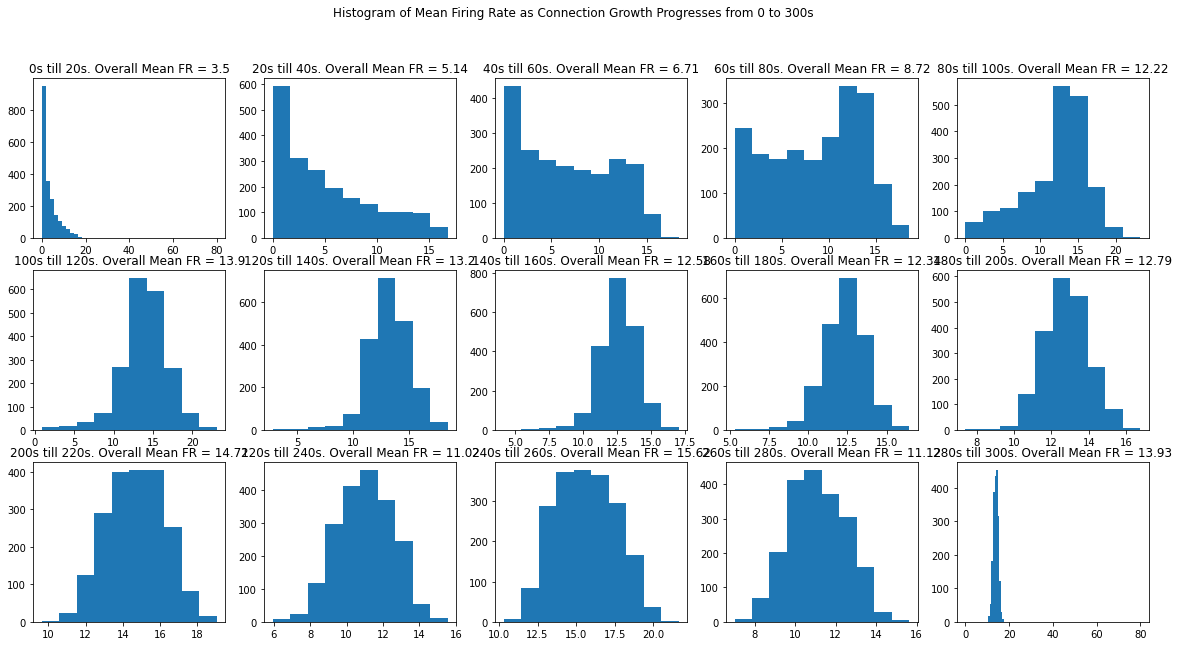

In [49]:
fig, ax = plt.subplots(nrows=3, ncols=5)
#, sharey=True, sharex=True)

fig.set_size_inches(20, 10)
ax = ax.flatten()

for idx, start in enumerate( range(0, 281, 20) ):
    mfr = s.time_slice(start * 1000, (start+20) * 1000).mean_rates()
    
    ax[idx].hist(mfr)
    
    ax[idx].title.set_text("{start}s till {stop}s. Overall Mean FR = {mean_mfr}"\
                           .format(start=start, stop=start+20, mean_mfr=round( np.mean(mfr), 2 )) )

ax[-1].hist(indeg_fr_hardwired.firing_rate, alpha=.3, density=True)
ax[0].hist(indeg_fr_hardwired.firing_rate, alpha=.3, density=True)

fig.suptitle("Histogram of Mean Firing Rate as Connection Growth Progresses from 0 to 300s");


In [13]:
df_hardwired = readnet('destexhe-scaleup-saveconn', 1)

pth = "../demyelination/data/destexhe-scaleup-hardwired/activity/"
fl = 'spk_destexhe-scaleup-hardwired_b=5.0_nu_x=4.0_w_exc=4.0_nuX_stim=15.0_w_th_stimscale=15.0'

s = pd.read_pickle(pth + fl).spikeobj['eA1']

indeg_hardwired = df_hardwired.target.value_counts()

indeg_fr_hardwired = pd.DataFrame(indeg_hardwired)

for idx in range(401, 2401):
    indeg_fr_hardwired.loc[idx, 'firing_rate'] = s.id_slice([idx]).time_slice(2 * 1000, 4 * 1000).mean_rates()[0]

In [51]:

pth = "../demyelination/data/destexhe-scaleup-tonotopic-grownconn/activity/"
fl = 'spk_destexhe-scaleup-tonotopic-grownconn_b=5.0_nu_x=4.0_w_exc=4.0_nuX_stim=15.0_w_th_stimscale=15.0'

s = pd.read_pickle(pth + fl).spikeobj['eA1']

indeg = df_plast_hundredupdate.target.value_counts()

indeg_fr_grownconn = pd.DataFrame(indeg)

for idx in range(401, 2401):
    indeg_fr_grownconn.loc[idx, 'firing_rate'] = s.id_slice([idx]).time_slice(4 * 1000, 5 * 1000).mean_rates()[0]

In [52]:
df_plast_hundredupdate = readnet('plasticity-debugging-noautapses-hundredupdate')

pth = "../demyelination/data/plasticity-debugging-noautapses-hundredupdate/activity/"
fl = 'spk_plasticity-debugging-noautapses-hundredupdate_T=0_'

s = gatherSpikes(pth, fl, 8, "eA1", 401, 2400)

indeg = df_plast_hundredupdate.target.value_counts()

indeg_fr = pd.DataFrame(indeg)

for idx in range(401, 2401):
    indeg_fr.loc[idx, 'firing_rate'] = s.id_slice([idx]).time_slice(280 * 1000, 300 * 1000).mean_rates()[0]

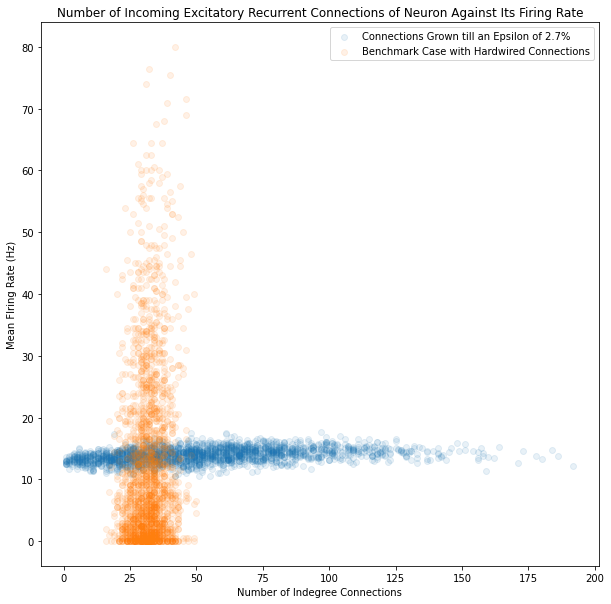

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10, 10)

ax.scatter(indeg_fr.target, indeg_fr.firing_rate, label="Connections Grown till an Epsilon of 2.7%", alpha=.1)
ax.scatter(indeg_fr_hardwired.target, indeg_fr_hardwired.firing_rate, label="Benchmark Case with Hardwired Connections", alpha=.1)
# ax.scatter(indeg_fr_grownconn.target, indeg_fr_grownconn.firing_rate, label="Plugging Grown Connections")

ax.set_xlabel("Number of Indegree Connections")
ax.set_ylabel("Mean FIring Rate (Hz)")

ax.set_title("Number of Incoming Excitatory Recurrent Connections of Neuron Against Its Firing Rate");

plt.legend();

In [54]:
indeg_fr_hardwired.target.min(), indeg_fr.target.min()

(16, 1.0)

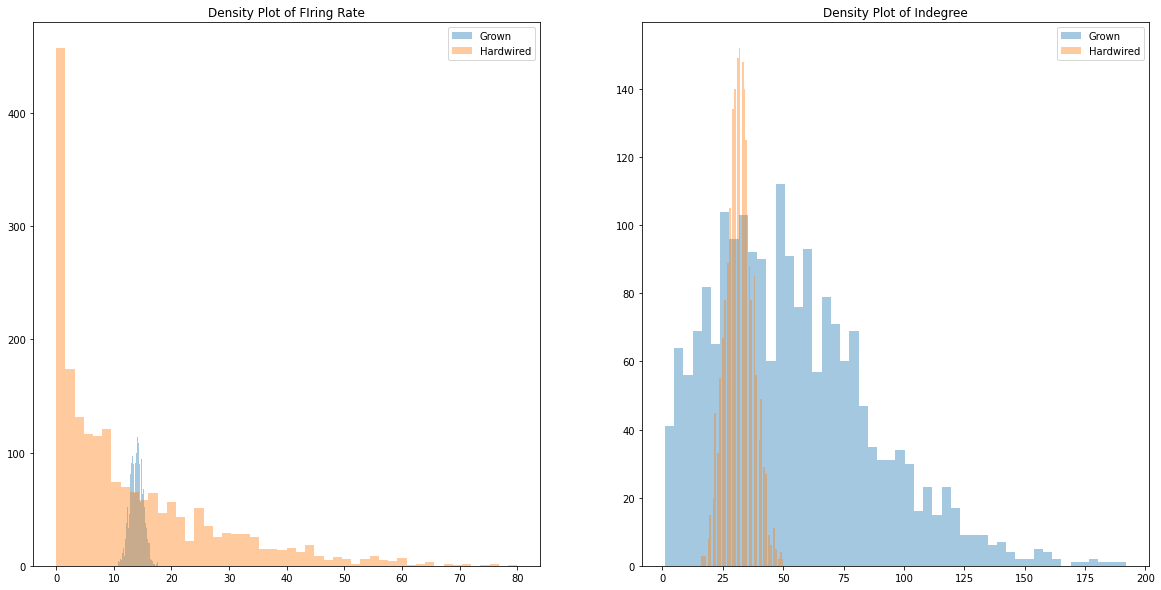

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(20, 10)

binsize = 50

den = False

ax[0].hist(indeg_fr.firing_rate, density=den, alpha=.4, label="Grown", bins=binsize);
ax[0].hist(indeg_fr_hardwired.firing_rate, density=den, alpha=.4, label="Hardwired", bins=binsize);

ax[1].hist(indeg_fr.target, density=den, alpha=.4, label="Grown", bins=binsize);
ax[1].hist(indeg_fr_hardwired.target, density=den, alpha=.4, label="Hardwired", bins=binsize);

ax[0].title.set_text("Density Plot of FIring Rate")
ax[1].title.set_text("Density Plot of Indegree")

[_.legend() for _ in ax];


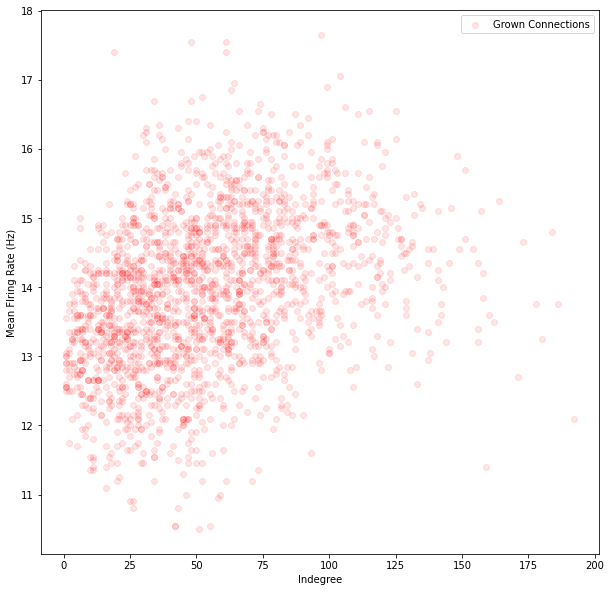

In [56]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)

# ax.scatter(indeg_fr_grownconn.target, indeg_fr_grownconn.firing_rate, alpha=.1, label="Reloaded Connection");

ax.scatter(indeg_fr.target, indeg_fr.firing_rate, c='r', alpha=.1, label="Grown Connections");

ax.set_ylabel("Mean FIring Rate (Hz)")
ax.set_xlabel("Indegree")

ax.legend()

In [75]:
df_plast_noadp = readnet('plasticity-debugging-noautapses-noadp')

pth = "../demyelination/data/plasticity-debugging-noautapses-noadp/activity/"
fl = 'spk_plasticity-debugging-noautapses-noadp_T=0_'

s = gatherSpikes(pth, fl, 8, "eA1", 401, 2400)

indeg = df_plast_noadp.target.value_counts()

indeg_noadp = pd.DataFrame(indeg)

for idx in range(401, 2401):
    indeg_noadp.loc[idx, 'firing_rate'] = s.id_slice([idx]).time_slice(280 * 1000, 300 * 1000).mean_rates()[0]

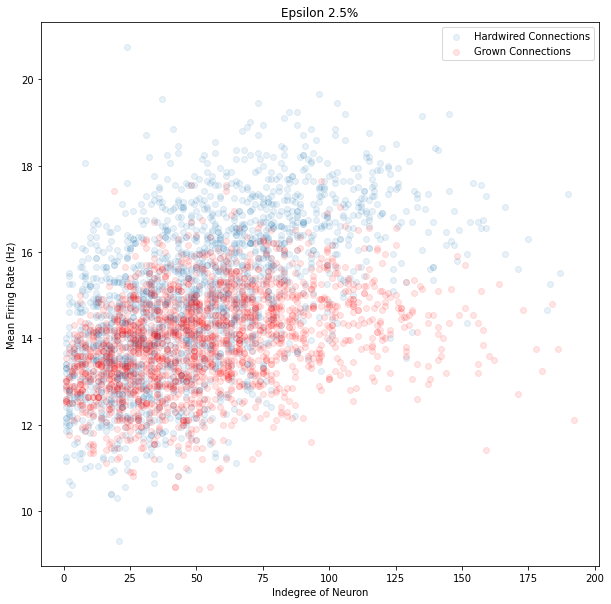

In [74]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)

ax.scatter(indeg_noadp.target, indeg_noadp.firing_rate, alpha=.1, label="Hardwired Connections");
ax.scatter(indeg_fr.target, indeg_fr.firing_rate, c='r', alpha=.1, label="Grown Connections");
ax.set_ylabel("Mean Firing Rate (Hz)");
ax.set_xlabel("Indegree of Neuron");

ax.title.set_text("Epsilon 2.5%");

ax.legend()

# plt.savefig("/home/pbr-student/Downloads/thesis-plots/indegree-noadaptation.pdf")

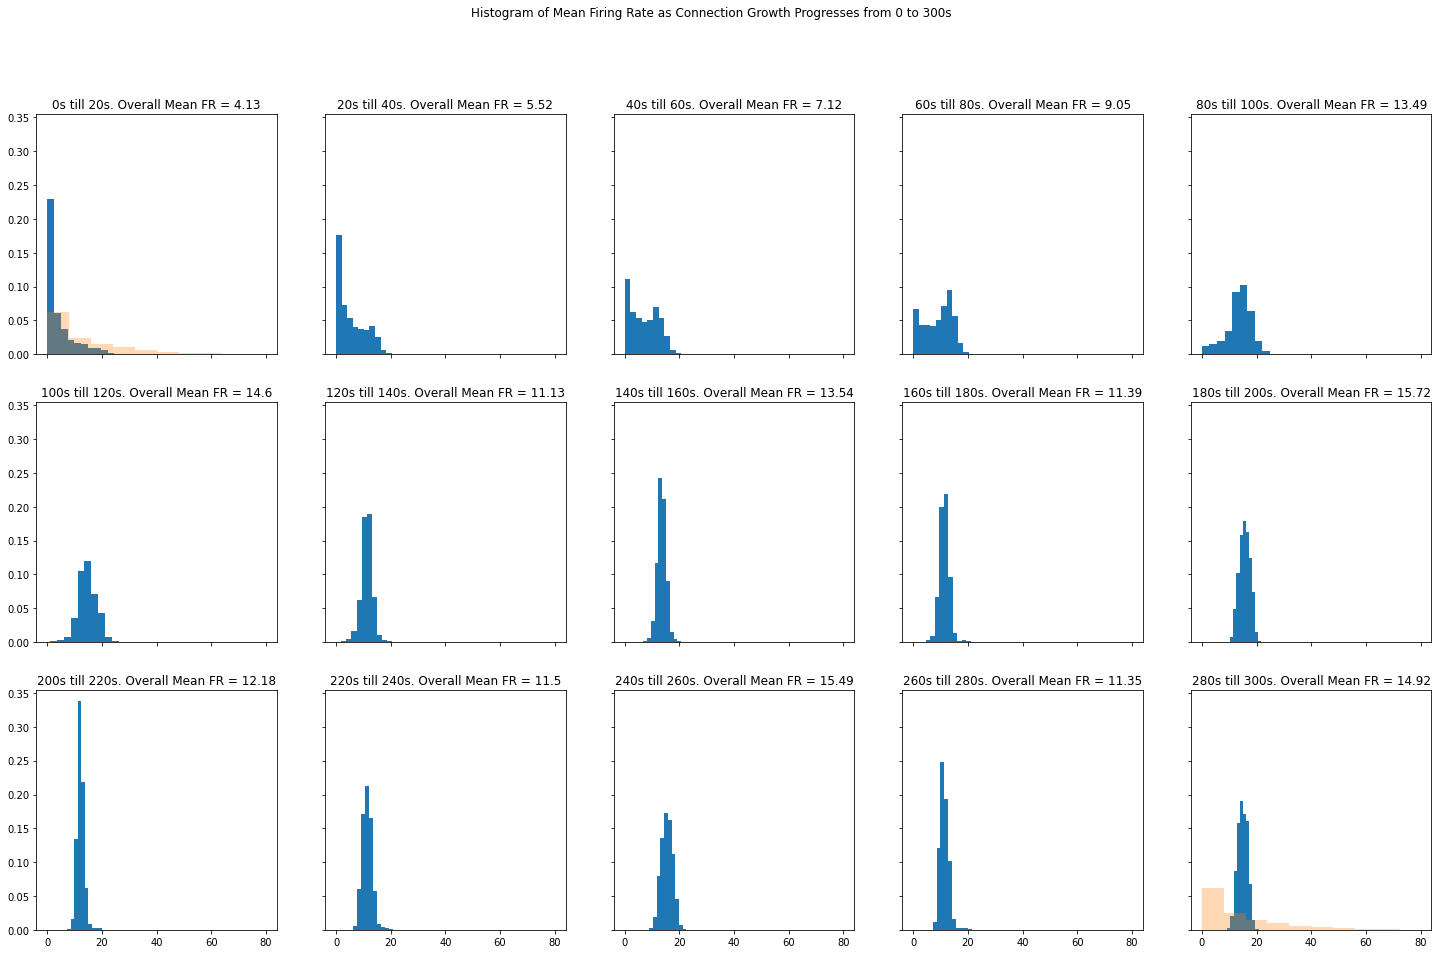

In [59]:
fig, ax = plt.subplots(nrows=3, ncols=5, sharey=True, sharex=True)
fig.set_size_inches(25, 15)
ax = ax.flatten()

for idx, start in enumerate( range(0, 281, 20) ):
    mfr = s.time_slice(start * 1000, (start+20) * 1000).mean_rates()
    
    ax[idx].hist(mfr, density=True)
    
    ax[idx].title.set_text("{start}s till {stop}s. Overall Mean FR = {mean_mfr}".format(start=start, stop=start+20, mean_mfr=round( np.mean(mfr), 2 )) )

ax[-1].hist(indeg_fr_hardwired.firing_rate, alpha=.3, density=True)
ax[0].hist(indeg_fr_hardwired.firing_rate, alpha=.3, density=True)

fig.suptitle("Histogram of Mean Firing Rate as Connection Growth Progresses from 0 to 300s");


## indegree over time

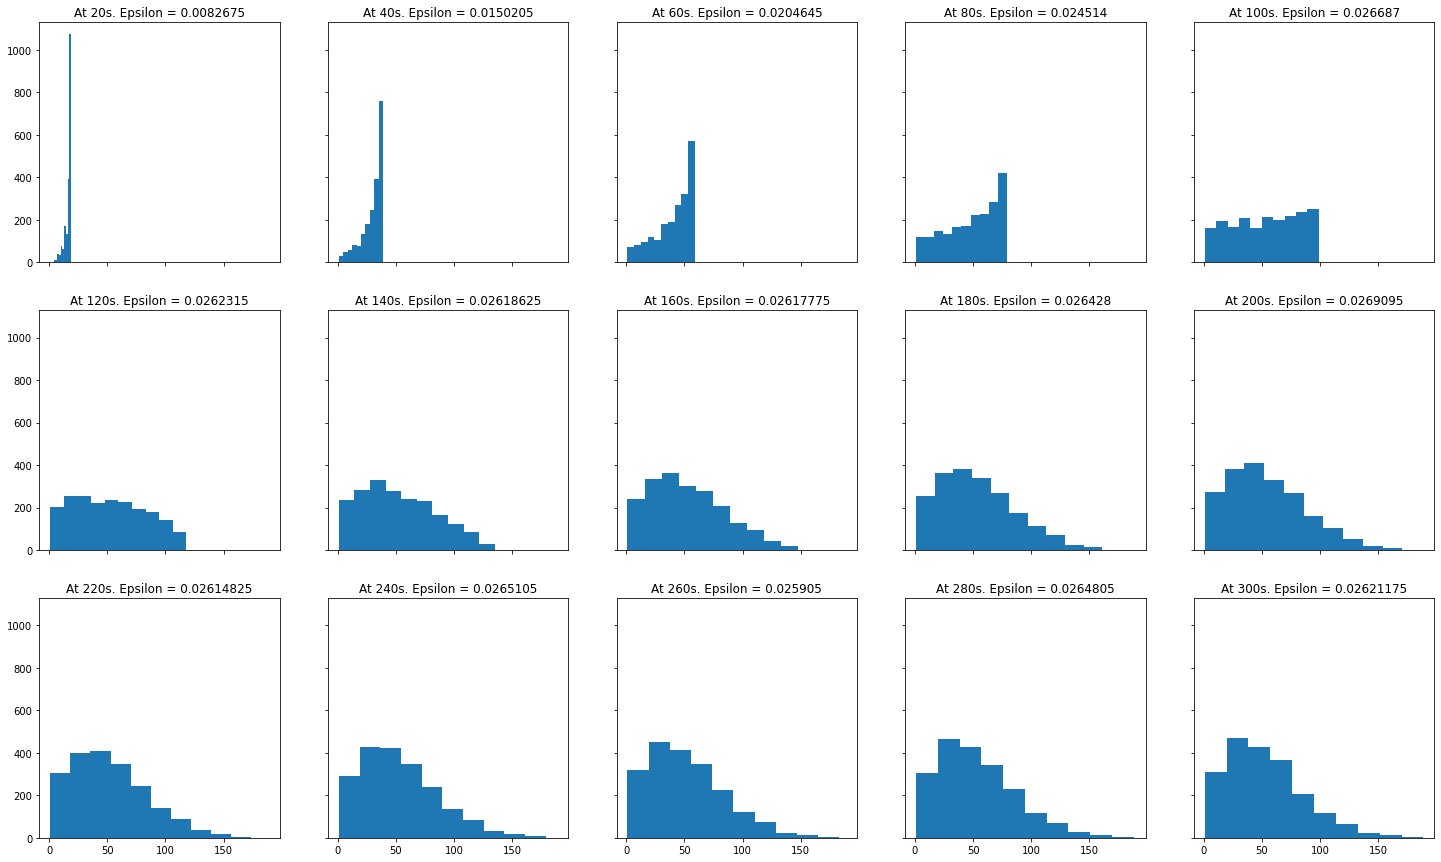

In [60]:
# pth = "../demyelination/data/plasticity-debugging-noautapses-hundredupdate/activity/"
# fl = 'spk_plasticity-debugging-noautapses-hundredupdate_T=0_'

fig, ax = plt.subplots(nrows=3, ncols=5, sharey=True, sharex=True)
fig.set_size_inches(25, 15)
ax = ax.flatten()

dfs = readnet_timeinterval('plasticity-debugging-noautapses-hundredupdate', 20000, 300000)

indeg_overtime = [_.target.value_counts() for _ in dfs]

for idx, start in enumerate( range(20, 301, 20) ):
    ax[idx].hist(indeg_overtime[idx], density=False)
    
    ax[idx].title.set_text("At {stop}s. Epsilon = {eps}".format(stop=start, eps= dfs[idx].shape[0]/(2000*2000) ) )

# ax[-1].hist(indeg_fr_hardwired.firing_rate, alpha=.3, density=True)
# ax[0].hist(indeg_fr_hardwired.firing_rate, alpha=.3, density=True)

# fig.suptitle("Histogram of Mean Firing Rate as Connection Growth Progresses from 0 to 300s");



## indegree over time no adaptation

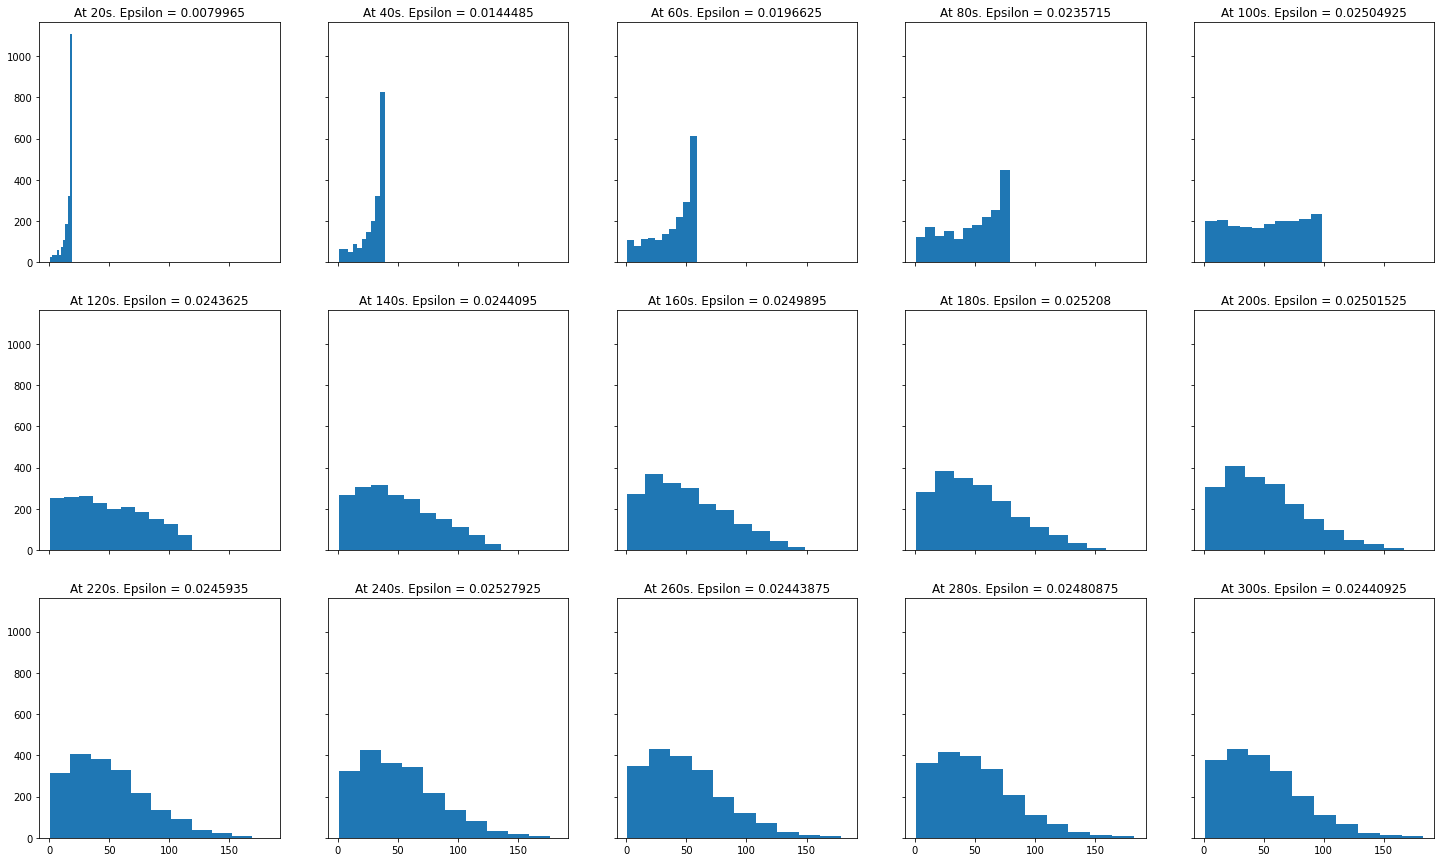

In [61]:
fig, ax = plt.subplots(nrows=3, ncols=5, sharey=True, sharex=True)
fig.set_size_inches(25, 15)
ax = ax.flatten()

dfs = readnet_timeinterval('plasticity-debugging-noautapses-noadp', 20000, 300000)

indeg_overtime = [_.target.value_counts() for _ in dfs]

for idx, start in enumerate( range(20, 301, 20) ):
    ax[idx].hist(indeg_overtime[idx], density=False)
    
    ax[idx].title.set_text("At {stop}s. Epsilon = {eps}".format(stop=start, eps= dfs[idx].shape[0]/(2000*2000) ) )

# ax[-1].hist(indeg_fr_hardwired.firing_rate, alpha=.3, density=True)
# ax[0].hist(indeg_fr_hardwired.firing_rate, alpha=.3, density=True)

# fig.suptitle("Histogram of Mean Firing Rate as Connection Growth Progresses from 0 to 300s");



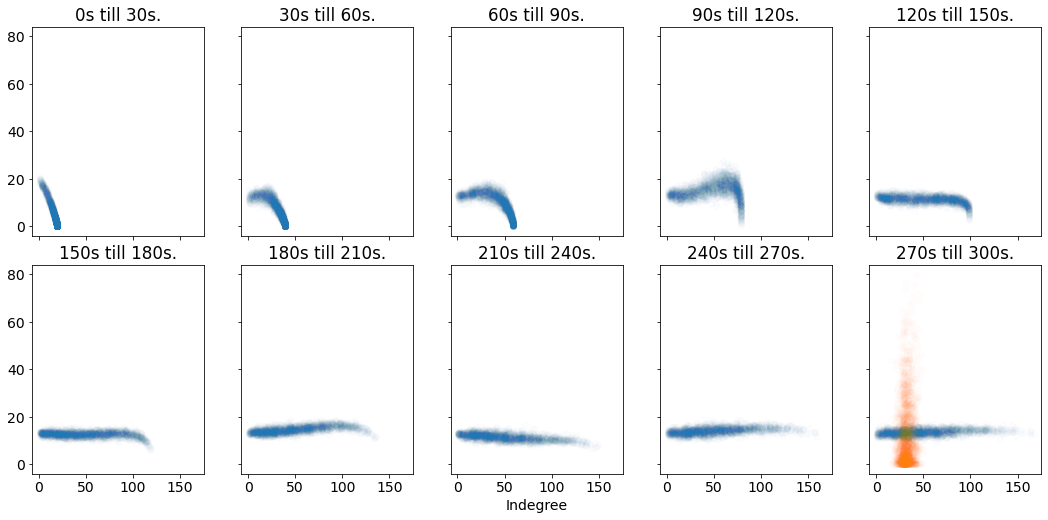

In [74]:
pth = "../demyelination/data/plasticity-debugging-noautapses-noadp/activity/"
fl = 'spk_plasticity-debugging-noautapses-noadp_T=0_'

s = gatherSpikes(pth, fl, 8, "eA1", 401, 2400)
nids = list(range(401, 2401))

dfs = readnet_timeinterval('plasticity-debugging-noautapses-noadp', 20 * 1000, 300 * 1000)

indeg_overtime = [_.target.value_counts() for _ in dfs]

fig, ax = plt.subplots(nrows=2, ncols=5, sharey=True, sharex=True, figsize=(15, 7))
fig.tight_layout()
# fig.set_size_inches(25, 15)
ax = ax.flatten()

for idx, start in enumerate( range(0, 271, 30) ):
    # compute the mean firing rates
    mfr = s.time_slice(start * 1000, (start+30) * 1000)\
            .id_slice(nids).mean_rates()
    
    # make a dataframe
    d = pd.DataFrame(data= {"mfr" : mfr, "neuron" : range(401, 2401)})
    d.index = d.neuron
    d["indg"] = indeg_overtime[idx]
    
    ax[idx].scatter(d.indg, d.mfr, alpha=0.01)
    
    #ax[idx].title.set_text("{start}s till {stop}s.\nOverall Mean FR = {mean_mfr}".format(start=start, stop=start+20, mean_mfr=round( np.mean(mfr), 1 )) )
    ax[idx].title.set_text("{start}s till {stop}s.".format(start=start, stop=start+30) )

# ax[5].set_ylabel("Mean Firing Rate (Hz)");
ax[7].set_xlabel("Indegree");

# ax[-1].hist(indeg_fr_hardwired.firing_rate, alpha=.3, density=True)
# ax[0].hist(indeg_fr_hardwired.firing_rate, alpha=.3, density=True)
# ax[0].scatter(indeg_fr_hardwired.target, indeg_fr_hardwired.firing_rate, alpha=.01, label="Pre-defined Connections")
ax[-1].scatter(indeg_fr_hardwired.target, indeg_fr_hardwired.firing_rate, alpha=.01, label="Pre-defined Connections");

# fig.legend()

# fig.suptitle("Scatter Plot of Mean Firing Rate against Number of Indegree as Connection Growth Progresses in Non Adaptive Neurons from 0 to 300s");


## 6s update interval

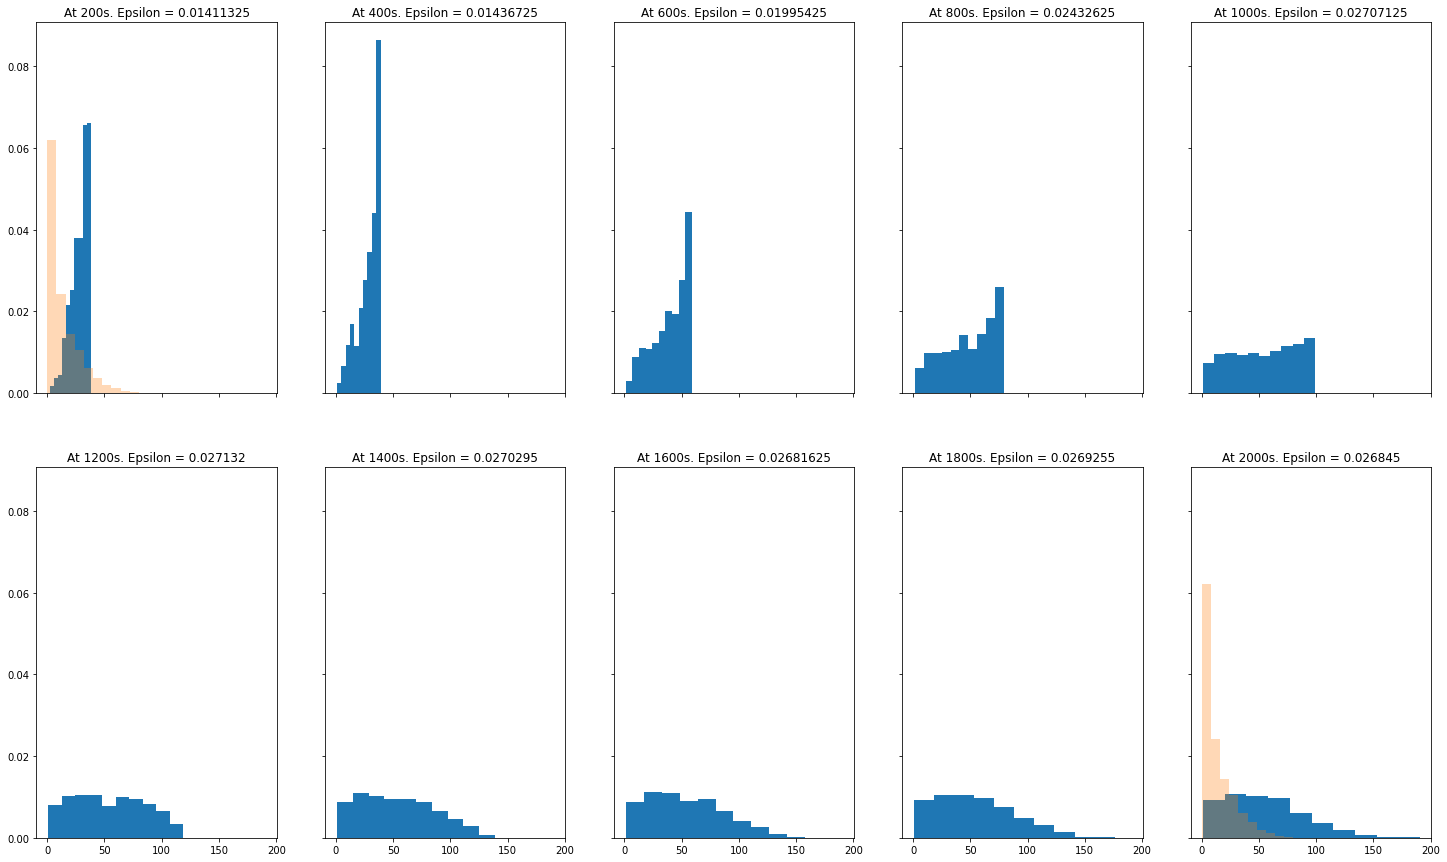

In [80]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharey=True, sharex=True)
fig.set_size_inches(25, 15)
ax = ax.flatten()

dfs = readnet_timeinterval('plasticity-noautapses-6supdate', 200000, 2000 * 1000)

indeg_overtime = [_.target.value_counts() for _ in dfs]

for idx, start in enumerate( range(200, 2001, 200) ):
    ax[idx].hist(indeg_overtime[idx], density=True)
    
    ax[idx].title.set_text("At {stop}s. Epsilon = {eps}".format(stop=start, eps= dfs[idx].shape[0]/(2000*2000) ) )

ax[-1].hist(indeg_fr_hardwired.firing_rate, alpha=.3, density=True);
ax[0].hist(indeg_fr_hardwired.firing_rate, alpha=.3, density=True);

# fig.suptitle("Histogram of Mean Firing Rate as Connection Growth Progresses from 0 to 300s");



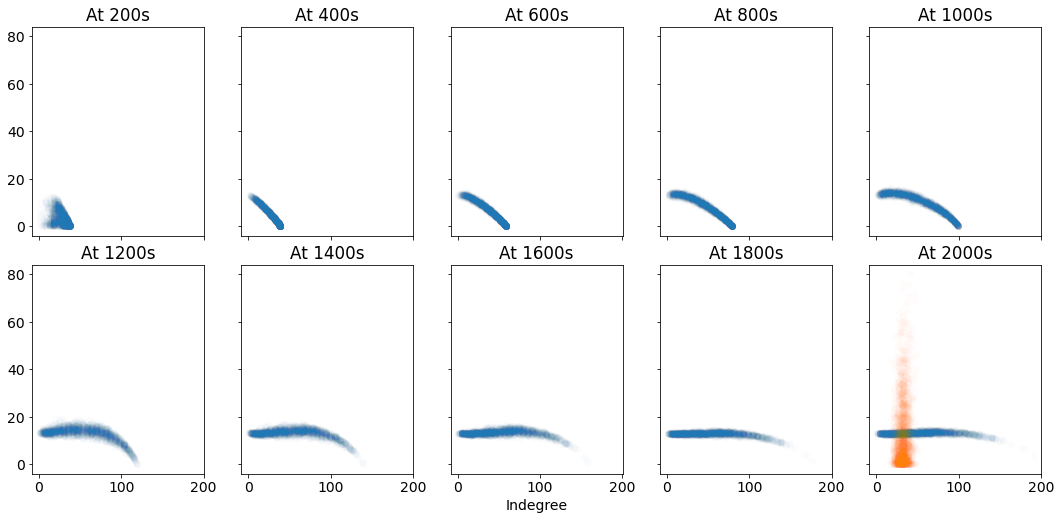

In [79]:
pth = "../demyelination/data/plasticity-noautapses-6supdate/activity/"
fl = 'spk_plasticity-noautapses-6supdate_T=0_'

s = gatherSpikes(pth, fl, 8, "eA1", 401, 2400)
nids = list(range(401, 2401))

dfs = readnet_timeinterval('plasticity-noautapses-6supdate', 200000, 2000 * 1000)

indeg_overtime = [_.target.value_counts() for _ in dfs]

fig, ax = plt.subplots(nrows=2, ncols=5, sharey=True, sharex=True, figsize=(15, 7))
fig.tight_layout()
ax = ax.flatten()

for idx, start in enumerate( range(0, 1801, 200) ):
    # compute the mean firing rates
    mfr = s.time_slice(start * 1000, (start+200) * 1000)\
            .id_slice(nids).mean_rates()
    
    # make a dataframe
    d = pd.DataFrame(data= {"mfr" : mfr, "neuron" : range(401, 2401)})
    d.index = d.neuron
    d["indg"] = indeg_overtime[idx]
    
    ax[idx].scatter(d.indg, d.mfr, alpha=0.01)
    
    ax[idx].title.set_text("At {stop}s".format(stop=start+200) )

# ax[5].set_ylabel("Mean Firing Rate (Hz)")
ax[7].set_xlabel("Indegree")

# ax[-1].hist(indeg_fr_hardwired.firing_rate, alpha=.3, density=True)
# ax[0].hist(indeg_fr_hardwired.firing_rate, alpha=.3, density=True)
ax[-1].scatter(indeg_fr_hardwired.target, indeg_fr_hardwired.firing_rate, alpha=.01, label="Pre-defined Connections");

# ax[0].legend()

# fig.suptitle("Scatter Plot of Mean Firing Rate against Number of Indegree as Connection Growth Progresses from 0 to 2000s");


NameError: name 'indeg_fr_hardwired' is not defined

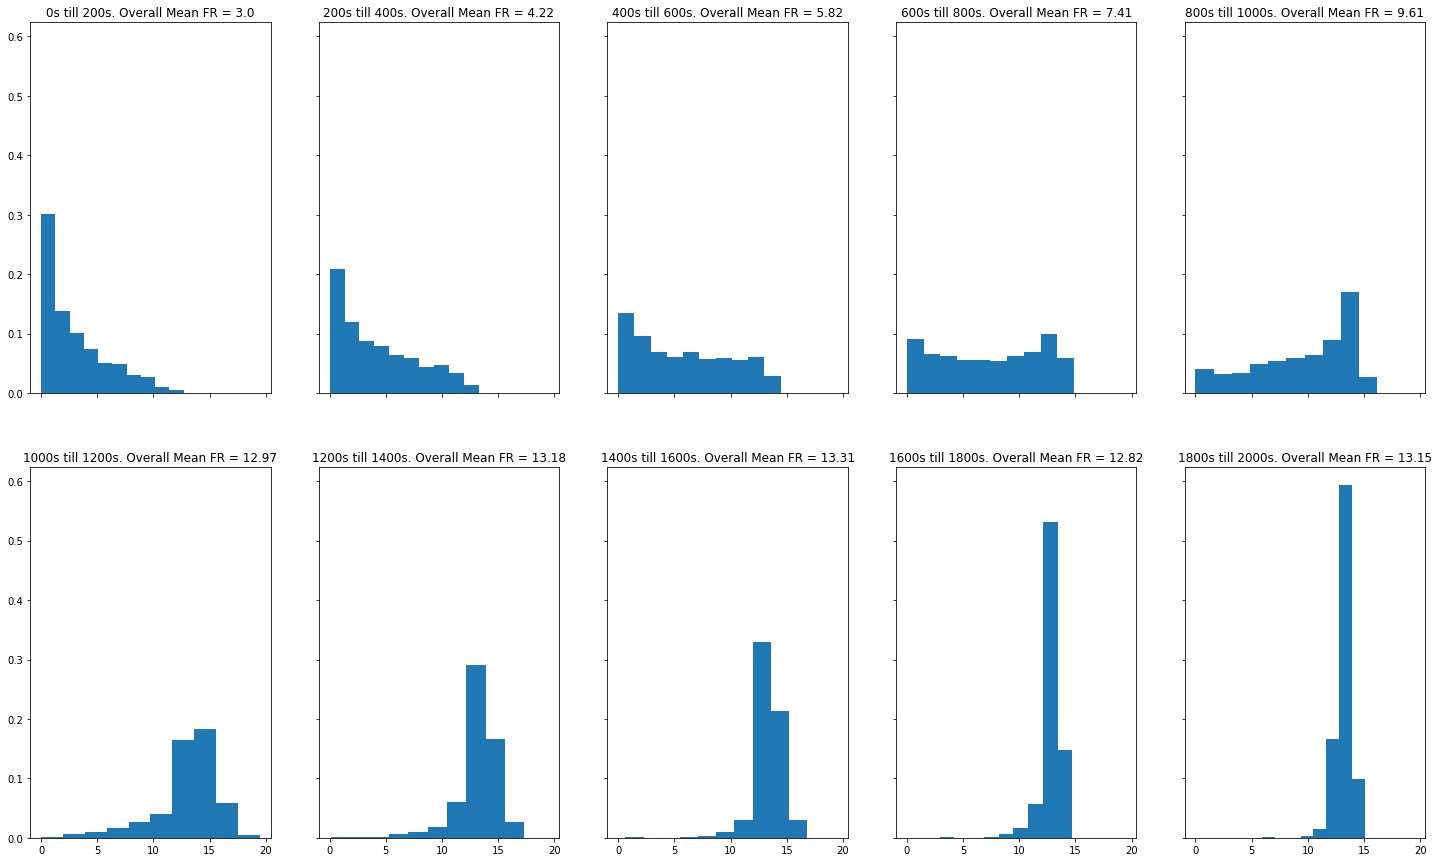

In [10]:
pth = "../demyelination/data/plasticity-noautapses-6supdate/activity/"
fl = 'spk_plasticity-noautapses-6supdate_T=0_'

s = gatherSpikes(pth, fl, 8, "eA1", 401, 2400)

fig, ax = plt.subplots(nrows=2, ncols=5, sharey=True, sharex=True)
fig.set_size_inches(25, 15)
ax = ax.flatten()

for idx, start in enumerate( range(0, 1801, 200) ):
    mfr = s.time_slice(start * 1000, (start+200) * 1000).mean_rates()
    
    ax[idx].hist(mfr, density=True)
    
    ax[idx].title.set_text("{start}s till {stop}s. Overall Mean FR = {mean_mfr}".format(start=start, stop=start+200, mean_mfr=round( np.mean(mfr), 2 )) )

ax[-1].hist(indeg_fr_hardwired.firing_rate, alpha=.3, density=True)
ax[0].hist(indeg_fr_hardwired.firing_rate, alpha=.3, density=True)

fig.suptitle("Histogram of Mean Firing Rate as Connection Growth Progresses from 0 to 2000s");


## plasticity-cadist

(array([0.0620625, 0.02425  , 0.0145   , 0.0105   , 0.0060625, 0.00375  ,
        0.0019375, 0.0011875, 0.0005   , 0.00025  ]),
 array([ 0.,  8., 16., 24., 32., 40., 48., 56., 64., 72., 80.]),
 <BarContainer object of 10 artists>)

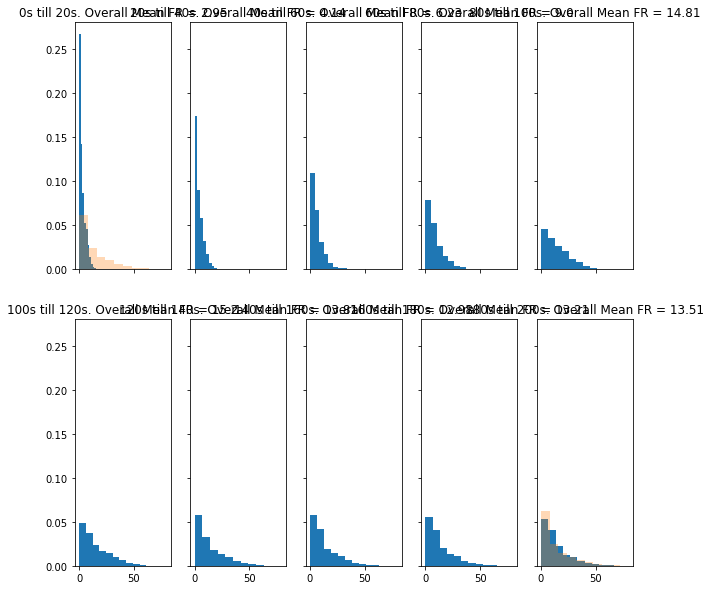

In [18]:
pth = "../demyelination/data/plasticity-cadist/activity/"
fl = 'spk_plasticity-cadist_T=0_'

s = gatherSpikes(pth, fl, 8, "eA1", 401, 2400)

fig, ax = plt.subplots(nrows=2, ncols=5, sharey=True, sharex=True, figsize=(10, 10))
# fig.set_size_inches(25, 15)
ax = ax.flatten()

for idx, start in enumerate( range(0, 181, 20) ):
    mfr = s.time_slice(start * 1000, (start+20) * 1000).mean_rates()
    
    ax[idx].hist(mfr, density=True)
    
    ax[idx].title.set_text("{start}s till {stop}s. Overall Mean FR = {mean_mfr}".format(start=start, stop=start+20, mean_mfr=round( np.mean(mfr), 2 )) )

ax[-1].hist(indeg_fr_hardwired.firing_rate, alpha=.3, density=True)
ax[0].hist(indeg_fr_hardwired.firing_rate, alpha=.3, density=True)

# fig.suptitle("Histogram of Mean Firing Rate as Connection Growth Progresses from 0 to 200s");


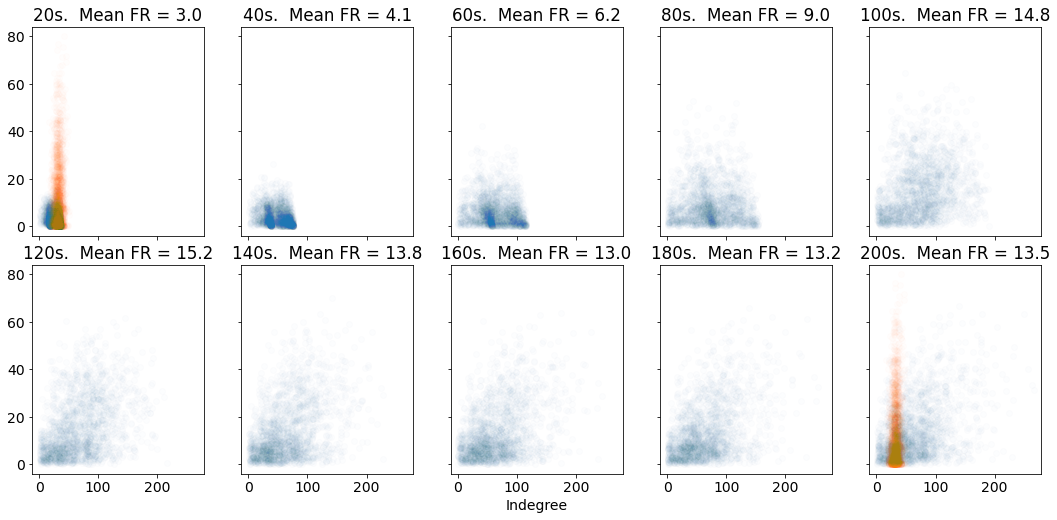

In [70]:
pth = "../demyelination/data/plasticity-cadist/activity/"
fl = 'spk_plasticity-cadist_T=0_'

s = gatherSpikes(pth, fl, 8, "eA1", 401, 2400)
nids = list(range(401, 2401))

dfs = readnet_timeinterval('plasticity-cadist', 20 * 1000, 200 * 1000)

indeg_overtime = [_.target.value_counts() for _ in dfs]

fig, ax = plt.subplots(nrows=2, ncols=5, sharey=True, sharex=True, figsize=(15, 7))
fig.tight_layout()
ax = ax.flatten()

for idx, start in enumerate( range(0, 181, 20) ):
    # compute the mean firing rates
    mfr = s.time_slice(start * 1000, (start+20) * 1000)\
            .id_slice(nids).mean_rates()
    
    # make a dataframe
    d = pd.DataFrame(data= {"mfr" : mfr, "neuron" : range(401, 2401)})
    d.index = d.neuron
    d["indg"] = indeg_overtime[idx]
    
    ax[idx].scatter(d.indg, d.mfr, alpha=0.01)
    
    ax[idx].title.set_text("{stop}s.  Mean FR = {mean_mfr}".format(start=start, stop=start+20, mean_mfr=round( np.mean(mfr), 1 )) )

# [ax[idx].set_ylabel("Mean Firing Rate (Hz)") for idx in [0, 5]];
ax[7].set_xlabel("Indegree")
    

# ax[-1].hist(indeg_fr_hardwired.firing_rate, alpha=.3, density=True)
# ax[0].hist(indeg_fr_hardwired.firing_rate, alpha=.3, density=True)
ax[0].scatter(indeg_fr_hardwired.target, indeg_fr_hardwired.firing_rate, alpha=.01, label="Pre-defined Connections")
ax[-1].scatter(indeg_fr_hardwired.target, indeg_fr_hardwired.firing_rate, alpha=.01, label="Pre-defined Connections")

# ax[0].legend()

# fig.suptitle("Scatter Plot of Mean Firing Rate against Number of Indegree as Connection Growth Progresses from 0 to 200s");


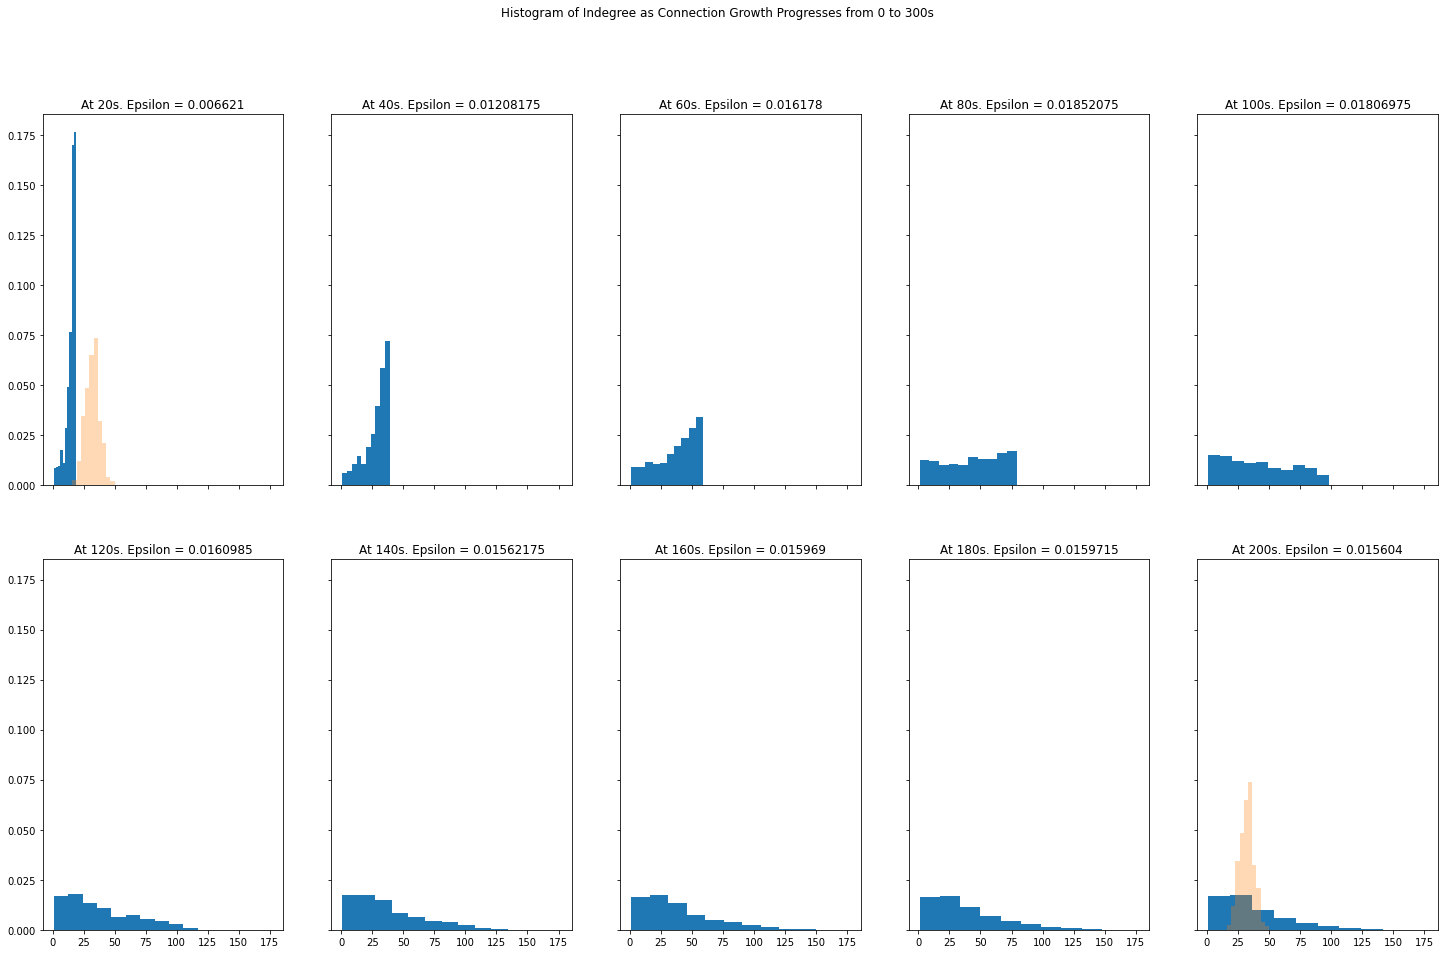

In [68]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharey=True, sharex=True)
fig.set_size_inches(25, 15)
ax = ax.flatten()

dfs = readnet_timeinterval_filterouteaone('plasticity-cadist-allconn', 20 * 1000, 200 * 1000, nthreads=1)

indeg_overtime = [_.target.value_counts() for _ in dfs]

for idx, start in enumerate( range(20, 201, 20) ):
    ax[idx].hist(indeg_overtime[idx], density=True)
    
    ax[idx].title.set_text("At {stop}s. Epsilon = {eps}".format(stop=start, eps= dfs[idx].shape[0]/(2000*2000) ) )

ax[-1].hist(indeg_fr_hardwired.target, alpha=.3, density=True);
ax[0].hist(indeg_fr_hardwired.target, alpha=.3, density=True);

fig.suptitle("Histogram of Indegree as Connection Growth Progresses from 0 to 300s");


# plt.savefig("/home/pbr-student/Downloads/thesis-plots/indegree-cadist.pdf")

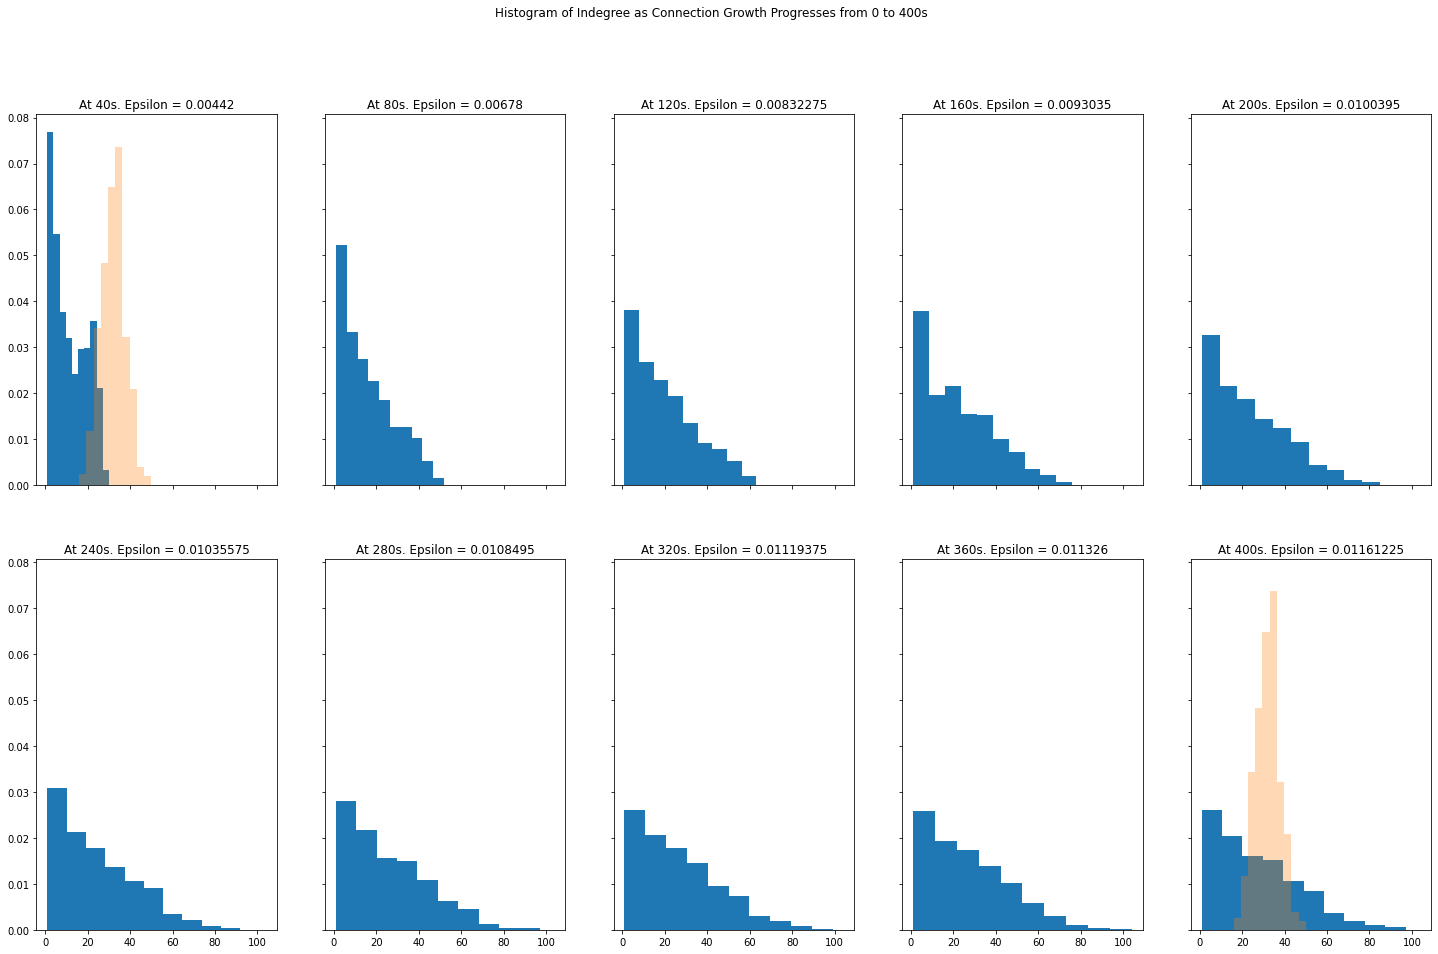

In [69]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharey=True, sharex=True)
fig.set_size_inches(25, 15)
ax = ax.flatten()

dfs = readnet_timeinterval_filterouteaone('plasticity-cadist-allconn-gauss', 40 * 1000, 400 * 1000, nthreads=1)

indeg_overtime = [_.target.value_counts() for _ in dfs]

for idx, start in enumerate( range(40, 401, 40) ):
    ax[idx].hist(indeg_overtime[idx], density=True)
    
    ax[idx].title.set_text("At {stop}s. Epsilon = {eps}".format(stop=start, eps= dfs[idx].shape[0]/(2000*2000) ) )

ax[-1].hist(indeg_fr_hardwired.target, alpha=.3, density=True);
ax[0].hist(indeg_fr_hardwired.target, alpha=.3, density=True);

fig.suptitle("Histogram of Indegree as Connection Growth Progresses from 0 to 400s");


# plt.savefig("/home/pbr-student/Downloads/thesis-plots/indegree-cadist.pdf")

In [243]:
df_cadist = readnet_timeinterval('plasticity-cadist', 20 * 1000, 200 * 1000, nthreads=1)[-1]

pth = "../demyelination/data/plasticity-cadist/activity/"
fl = 'spk_plasticity-cadist_T=0_'

s = gatherSpikes(pth, fl, 8, "eA1", 401, 2400)

indeg = df_cadist.target.value_counts()

indeg_cadist = pd.DataFrame(indeg)

for idx in range(401, 2401):
    indeg_cadist.loc[idx, 'firing_rate'] = s.id_slice([idx]).time_slice(180 * 1000, 200 * 1000).mean_rates()[0]

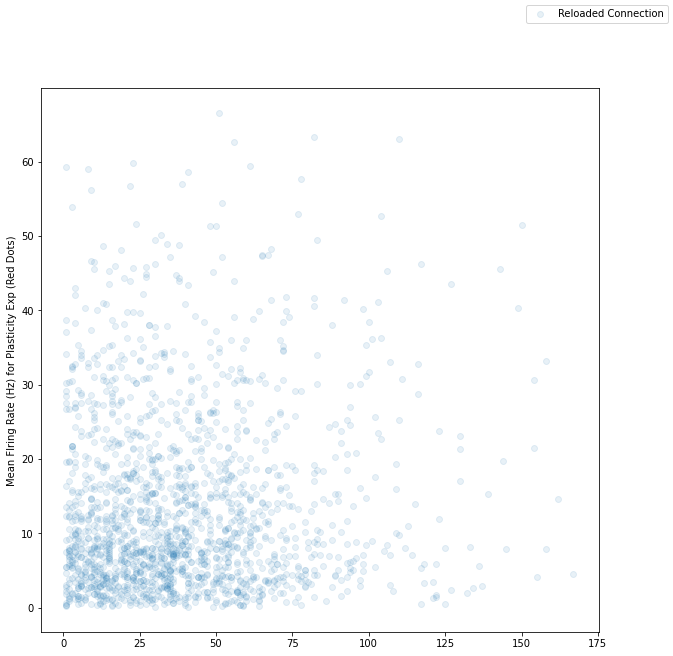

In [242]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)

# ax2 = ax.twinx()

ax.scatter(indeg_cadist.target, indeg_cadist.firing_rate, alpha=.1, label="Reloaded Connection");

# ax2.scatter(indeg_fr.target, indeg_fr.firing_rate, c='r', alpha=.1, label="Grown Connections");

ax.set_ylabel("Mean FIring Rate (Hz) for Plasticity Exp (Red Dots)")

fig.legend()